In [1]:
from model import ToyNet, UNet
from diffusion import DiffusionProcess
import torch
from diffusion.utils.sde import SDE
import numpy as np
import logging

from pytorch_lightning import LightningDataModule
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib import gridspec
import torch.nn as nn
from torch.distributions import Normal, Categorical, MixtureSameFamily
import torch
#device = 'mps'
device = 'cuda:0'
import random

In [2]:
# Data distribution
mix = Categorical(torch.ones(2,))
comp = Normal(torch.tensor([0 - 2., 0 + 2.]), torch.tensor([.5, .5]))
data_dist = MixtureSameFamily(mix, comp)


In [3]:
class SDEProcess(DiffusionProcess):
    def __init__(self, sde_type="VP",
                 sde_info={"VP": {"beta_min": 0.1, "beta_max": 20},
                           "subVP": {"beta_min": 0.1, "beta_max": 20},
                           "VE": {"sigma_min": 0.01, "sigma_max": 50}}, 
                 **kwargs):
        super(SDEProcess, self).__init__(**kwargs)
        assert self.discrete is False, "DDPM is only for continuous data"
        self.dt = 1. / self.total_steps # step size
        self.sde = SDE(self.total_steps, sde_type, sde_info)
        
    def forward_one_step(self, x_prev, t):
        """
        Discretized forward SDE process for actual compuatation: 
        x_{t+1} = x_t + f_t(x_t) * dt + G_t * z_t * sqrt(dt)
        """
        f_t, g_t = self.sde.drifts(x_prev, t-1)
        z = torch.randn_like(x_prev)
        x_t = x_prev + f_t * self.dt + g_t * z * np.sqrt(self.dt)
        return x_t

    
    def backward_one_step(self, x_t, t, pred_score, clip_denoised=True):
        """
        Discretized backward SDE process for actual compuatation:
        x_{t-1} = x_t - (f_t(x_t) - (G_t)^2 * pred_score) * dt + G_t * z_t * sqrt(dt)
        """
        z = torch.randn_like(x_t).to(device)
        f_t, g_t = self.sde.drifts(x_t, t)
        f_t = f_t.to(device)
        x_prev = x_t - (f_t - g_t**2 * pred_score) * self.dt + g_t * z * np.sqrt(self.dt)
        if clip_denoised and x_t.ndim > 2:
            print('backward_one_step')
            x_prev.clamp_(-1., 1.)

        return x_prev

    @torch.no_grad()
    def sample(self, noise, net):
        """
        Sample from backward diffusion process
        """
        x_t = noise
        trajs = [x_t]

        for t in reversed(range(1, self.total_steps+1)):
            pred_score = net(x_t, t)
            x_t = self.backward_one_step(x_t, t, pred_score)
            trajs.append(x_t)
        return x_t, torch.hstack(trajs)
    
    def forward_sample(self, data):
        trajs = torch.zeros([len(data), self.total_steps+1])
        x = data.to(device)
        trajs[:, 0] = x
        for t in range(1, self.total_steps+1):
            x = self.forward_one_step(x, t)
            trajs[:, t] = x
        return x, trajs
    
    def backward_sample(self, noise, net):
        """
        Sample from backward diffusion process
        """
        x_t = noise
        trajs = [x_t]

        for t in reversed(range(1, self.total_steps+1)):
            pred_score = net(x_t, t)
            x_t = self.backward_one_step(x_t, t, pred_score)
            trajs.append(x_t)
        return x_t, torch.hstack(trajs)


In [4]:

score_net = ToyNet(data_dim=1).to(device)
total_steps = 100
num_paths = 32
diffusion = SDEProcess(discrete=False, total_steps=total_steps, sde_type="VP")

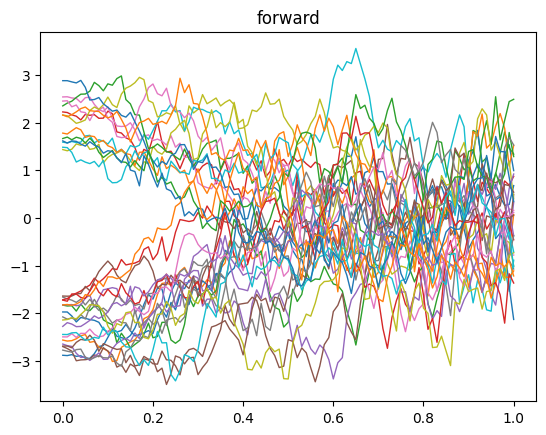

In [5]:
x_data_test = data_dist.sample([num_paths])
x_noise_test, traj_forward_test = diffusion.forward_sample(x_data_test)

xxx = np.linspace(0, 1, traj_forward_test.shape[1])
for line in traj_forward_test:
    plt.plot(xxx, line, linewidth=1.0)
    plt.title('forward')

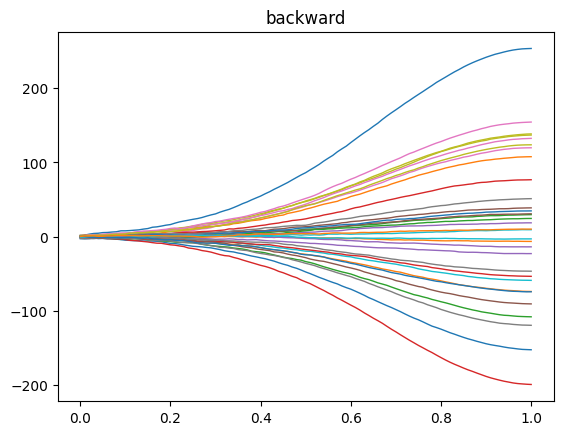

In [6]:
x_gen, traj_back = diffusion.sample(torch.randn([num_paths, 1]).to(device), score_net)
xxx = np.linspace(0, 1, traj_forward_test.shape[1])
for line in traj_back:
    plt.plot(xxx, line.cpu(), linewidth=1.0)
    plt.title('backward')

Train the network with PCF distance and reconstrucion loss. 

I haven't add time dimension to the input so far in this implementation bacause it doesn't work well now. If anyone wants to add time dimension, just replace pcf = PCF_with_empirical_measure(16, 12, 1) with pcf = PCF_with_empirical_measure(16, 12, 1, add_time=True) in belowing code cell.

Current implementation is not stable. Sometimes you may not get the backward figure as I show below. In this case, training extra 50 or 100 epoches may bring the similar result.  Anyway, I will keep working on it. 

In [24]:
from src.PCF_with_empirical_measure import PCF_with_empirical_measure

pcf = PCF_with_empirical_measure(16, 12, 1)
pcf = pcf.to(device)

num_epochs = 200
opt = torch.optim.Adam(score_net.parameters(), lr=1e-3)

for i in range(num_epochs):

    opt.zero_grad()
    x_data = data_dist.sample([num_paths])
    x_noise, traj_forward = diffusion.forward_sample(x_data)
    traj_forward = traj_forward.to(device)
    # Backward process to generate time series
    x_gen, traj_back = diffusion.backward_sample(torch.randn([num_paths, 1]).to(device), score_net)
    x_gen1, traj_back1 = diffusion.backward_sample(traj_forward[:,-1].unsqueeze(1).to(device), score_net) 
    traj_back_flip = torch.fliplr(traj_back)
    traj_back_flip1 = torch.fliplr(traj_back1)
    loss = (pcf.distance_measure(traj_forward.view([-1, total_steps+1, 1]), traj_back_flip.view([-1, total_steps+1, 1]), Lambda=1.0)
                        + torch.mean(((traj_forward - traj_back_flip1)**2).reshape(traj_back.shape[0], -1), dim=(0,1)))
    loss.backward()
    opt.step()
    print(i, loss)

0 tensor(5.9893, device='cuda:0', grad_fn=<AddBackward0>)
1 tensor(6.1026, device='cuda:0', grad_fn=<AddBackward0>)
2 tensor(6.0303, device='cuda:0', grad_fn=<AddBackward0>)
3 tensor(7.5913, device='cuda:0', grad_fn=<AddBackward0>)
4 tensor(7.7922, device='cuda:0', grad_fn=<AddBackward0>)
5 tensor(5.8143, device='cuda:0', grad_fn=<AddBackward0>)
6 tensor(7.2849, device='cuda:0', grad_fn=<AddBackward0>)
7 tensor(7.3802, device='cuda:0', grad_fn=<AddBackward0>)
8 tensor(6.5618, device='cuda:0', grad_fn=<AddBackward0>)
9 tensor(4.9053, device='cuda:0', grad_fn=<AddBackward0>)
10 tensor(5.1320, device='cuda:0', grad_fn=<AddBackward0>)
11 tensor(5.5813, device='cuda:0', grad_fn=<AddBackward0>)
12 tensor(6.0279, device='cuda:0', grad_fn=<AddBackward0>)
13 tensor(5.5563, device='cuda:0', grad_fn=<AddBackward0>)
14 tensor(6.6225, device='cuda:0', grad_fn=<AddBackward0>)
15 tensor(6.0740, device='cuda:0', grad_fn=<AddBackward0>)
16 tensor(4.7479, device='cuda:0', grad_fn=<AddBackward0>)
17 tens

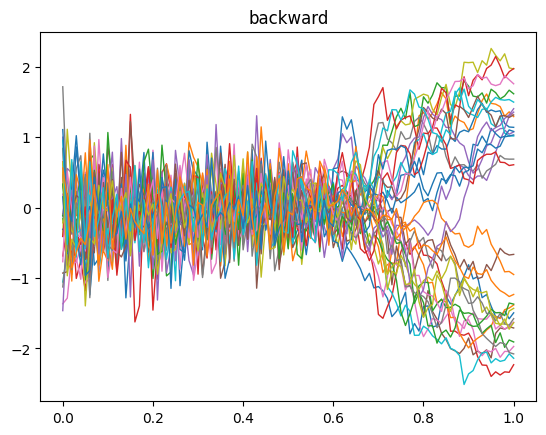

In [27]:
x_gen, traj_back = diffusion.sample(torch.randn([num_paths, 1]).cuda(), score_net)
xxx = np.linspace(0, 1, traj_forward.shape[1])
for line in traj_back:
    plt.plot(xxx, line.cpu(), linewidth=1.0)
    plt.title('backward')

Train the model only using reconstruction loss. It doesn't give a good result. Can find a better loss to replace reconstrcton loss. After I find a better loss, combining PCF loss with another better loss should bring better and more stable results. 

In [ ]:
from src.PCF_with_empirical_measure import PCF_with_empirical_measure

pcf = PCF_with_empirical_measure(16, 12, 1)
pcf = pcf.to(device)

num_epochs = 200
opt = torch.optim.Adam(score_net.parameters(), lr=1e-3)
for i in range(num_epochs):
    # Forward process to generate time series
    opt.zero_grad()
    x_data = data_dist.sample([num_paths])
    x_noise, traj_forward = diffusion.forward_sample(x_data)
    traj_forward = traj_forward.to(device)
    # Backward process to generate time series
    x_gen1, traj_back1 = diffusion.backward_sample(traj_forward[:,-1].unsqueeze(1).to(device), score_net) 
    traj_back_flip1 = torch.fliplr(traj_back1)
    loss = (torch.mean(((traj_forward - traj_back_flip1)**2).reshape(traj_back_flip1.shape[0], -1), dim=(0,1)))
    loss.backward()
    opt.step()
    print(i, loss)

0 tensor(3.5815, device='cuda:0', grad_fn=<MeanBackward1>)
1 tensor(3.5688, device='cuda:0', grad_fn=<MeanBackward1>)
2 tensor(2.9778, device='cuda:0', grad_fn=<MeanBackward1>)
3 tensor(2.4023, device='cuda:0', grad_fn=<MeanBackward1>)
4 tensor(2.1398, device='cuda:0', grad_fn=<MeanBackward1>)
5 tensor(2.0433, device='cuda:0', grad_fn=<MeanBackward1>)
6 tensor(1.9749, device='cuda:0', grad_fn=<MeanBackward1>)
7 tensor(2.2298, device='cuda:0', grad_fn=<MeanBackward1>)
8 tensor(2.2338, device='cuda:0', grad_fn=<MeanBackward1>)
9 tensor(2.4067, device='cuda:0', grad_fn=<MeanBackward1>)
10 tensor(2.4999, device='cuda:0', grad_fn=<MeanBackward1>)
11 tensor(2.3914, device='cuda:0', grad_fn=<MeanBackward1>)
12 tensor(2.1538, device='cuda:0', grad_fn=<MeanBackward1>)
13 tensor(2.5826, device='cuda:0', grad_fn=<MeanBackward1>)
14 tensor(2.0554, device='cuda:0', grad_fn=<MeanBackward1>)
15 tensor(2.0613, device='cuda:0', grad_fn=<MeanBackward1>)
16 tensor(2.2246, device='cuda:0', grad_fn=<MeanBa

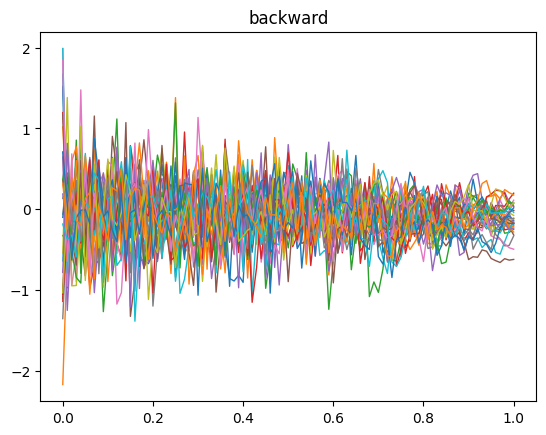

In [ ]:
x_gen, traj_back = diffusion.sample(torch.randn([num_paths, 1]).cuda(), score_net)
xxx = np.linspace(0, 1, traj_forward.shape[1])
for line in traj_back:
    plt.plot(xxx, line.cpu(), linewidth=1.0)
    plt.title('backward')

Train the model only using PCF loss. 

(So far I don't get a good result after adding time dimension.) 



In [ ]:
from src.PCF_with_empirical_measure import PCF_with_empirical_measure

pcf = PCF_with_empirical_measure(16, 12, 1, add_time=True)
pcf = pcf.to(device)

num_epochs = 200
opt = torch.optim.Adam(score_net.parameters(), lr=1e-3)
for i in range(num_epochs):
    # Forward process to generate time series
    opt.zero_grad()
    x_data = data_dist.sample([num_paths])
    x_noise, traj_forward = diffusion.forward_sample(x_data)
    traj_forward = traj_forward.to(device)
    # Backward process to generate time series
    x_gen, traj_back = diffusion.backward_sample(torch.randn([num_paths, 1]).to(device), score_net)
    traj_back_flip = torch.fliplr(traj_back)
    loss = pcf.distance_measure(traj_forward.view([-1, total_steps+1, 1]), 
                                traj_back_flip.view([-1, total_steps+1, 1]), Lambda=1.0) 

    loss.backward()
    opt.step()
    print(i, loss)

In [ ]:
x_gen, traj_back = diffusion.sample(torch.randn([num_paths, 1]).cuda(), score_net)
xxx = np.linspace(0, 1, traj_forward.shape[1])
for line in traj_back:
    plt.plot(xxx, line.cpu(), linewidth=1.0)
    plt.title('backward')